# LoC Data Package Tutorial: Free to Use collection

This notebook will demonstrate basic usage of using the Pyton library `boto3` for interacting with [data packages from the Library of Congress](https://labs.loc.gov/data/) via the [Free to Use data package](https://labs.loc.gov/data/explore/free-to-use/) which is derived from the Library's [Free to Use and Reuse Sets](https://loc.gov/free-to-use/). We will:

1. [List all available data packages from the Library](#List-available-data-packages)
2. [Output a summary of the contents of a particular data package](#Output-data-package-summary)
3. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
4. [Download and display images from a data package](#Download-and-display-images)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## List available data packages

First, we will display what data packages are available to explore

In [1]:
import io
import json
import math
import os

import boto3                            # for interacting with Amazon S3 (where the data is stored)
from IPython.display import display     # for displaying images
import pandas as pd                     # for reading, manipulating, and displaying data
from PIL import Image                   # for creating, reading, and manipulating images

BUCKET_NAME = 'data.labs.loc.gov' # The name of public S3 bucket

# Connect to Amazon S3
s3 = boto3.client('s3')

# List only the top-level subdirectories which correspond to data packages
response = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix='', Delimiter='/')
for obj in response.get('CommonPrefixes'):
    print(obj.get('Prefix'))

digitized-books/
directories-by-region/
directories/
ftu/
gen-coll-assessment/
jukebox/
maps/
stereographs/
telephone/


## Output data package summary

Next we will select one data package (The [Free to Use Data Package](https://labs.loc.gov/data/explore/free-to-use/)) and output a summary of it's contents

In [2]:
# This is the name of the data package from the list above; note the trailing slash
DATA_PACKAGE = 'ftu/'

# For keeping track of files, grouped by file type
ftypes = {}

# Since list_objects_v2 is limited to 1000 results, we need to paginate the results
paginator = s3.get_paginator("list_objects_v2")
page_iterator = paginator.paginate(Bucket=BUCKET_NAME, Prefix=DATA_PACKAGE)
for page in page_iterator:

    # Loop through the results
    for obj in page.get('Contents', []):
        filename, file_extension = os.path.splitext(obj['Key'])

        # Skip directories
        if file_extension == '':
            continue
        
        # Keep track of count and size
        if file_extension not in ftypes:
            ftypes[file_extension] = {'Count': 0, 'Size': 0}
        ftypes[file_extension]['Count'] += 1
        ftypes[file_extension]['Size'] += obj['Size']

# Convert to list, sort file types by total size
stats = [{'FileType': ext, 'Count': ftypes[ext]['Count'], 'Size': ftypes[ext]['Size']} for ext in ftypes]
stats = sorted(stats, key=lambda s: -s['Size'])

# Format numbers
for i, s in enumerate(stats):
    stats[i]['Count'] = f'{s["Count"]:,}'
    kb = round(s["Size"]/1000.0)
    mb = round(s["Size"]/1000000.0)
    stats[i]['Size'] = f'{mb:,}MB' if mb > 1 else f'{kb:,}KB'

# Convert to Pandas DataFrame and show table
pd.DataFrame(stats)

,FileType,Count,Size
0,.jpg,"2,635","1,108MB"
1,.zip,2,"1,100MB"
2,.json,2,16MB
3,.jsonl,2,12MB
4,.csv,6,10MB
5,.txt,3,271KB
6,.pdf,1,222KB
7,.html,1,94KB
8,.md,2,48KB


## Query the metadata in a data package

Next we will download a data package's metadata, print a summary of the items' subject values, then filter by a particular subject.

All data packages have a metadata file in .json and .csv formats. Let's load the "Free to Use" data package's `metadata.json` file:

In [3]:
obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}metadata.json')
contents = obj.get('Body', '[]').read() # Read contents as a string
data = json.loads(contents) # Parse string as JSON
print(f'Loaded metadata file with {len(data):,} entries.')

Loaded metadata file with 2,688 entries.


Next let's convert to pandas DataFrame and print the available properties

In [4]:
df = pd.DataFrame(data)
print(', '.join(df.columns.to_list()))

Call_number, Contributors, Date_text, Date, Digitized, Set, Genre, Id, IIIF_manifest, Preview_url, Index, Other_title, Description, Creators, Type_of_resource, Location_text, Other_record_formats, Rights, Source_collection, Language, Lccn, Medium, Mime_type, Notes, Online_format, Original_format, Part_of, Repository, Number_of_files, Shelf_id, Subjects, Subject_headings, Last_updated_in_api, Title, Url, Location


Next print the top 10 most frequent Subjects in this dataset

In [5]:
# Since "Subjects" are a list, we must "explode" it so there's just one subject per row
# We convert to DataFrame so it displays as a table
df['Subjects'].explode().value_counts().iloc[:10].to_frame()

,Subjects
united states,1104
color,854
photographic prints,346
portrait photographs,276
america,238
glass negatives,236
digital photographs,201
american,177
washington (d.c.),155
new york (state),149


Now we filter the results to only those items with subject "washington (d.c.)"

In [6]:
df_by_subject = df.explode('Subjects')
dc_set = df_by_subject[df_by_subject.Subjects == 'washington (d.c.)']
print(f'Found {dc_set.shape[0]:,} items with subject "washington (d.c.)"')

Found 155 items with subject "washington (d.c.)"


## Download and display images

Finally we will download and display the first 4 images that have subject "washington (d.c.)"

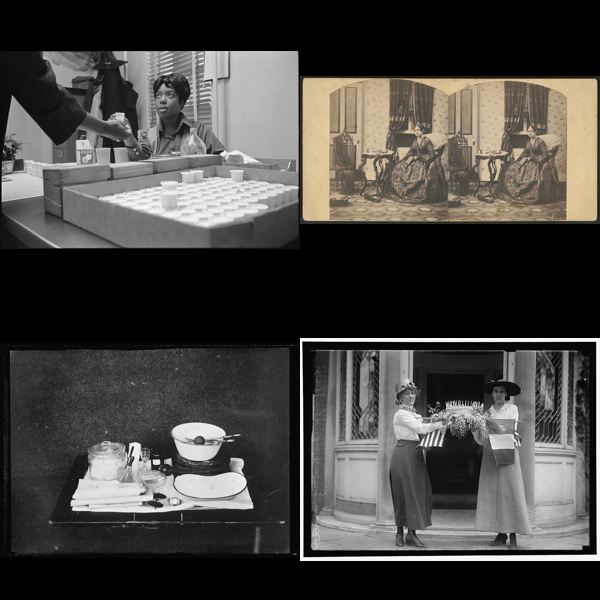

In [7]:
count = 4
dc_set = dc_set.head(count).reset_index()

# Define image dimensions
image_w = 600
image_h = 600
cols = math.ceil(count / 2.0)
rows = math.ceil(count / 2.0)
cell_w = image_w / cols
cell_h = image_h / rows

# Create base image
base_image = Image.new("RGB", (image_w, image_h))

# Loop through image URLs
for i, row in dc_set.iterrows():
    # Derive the filename from the item's URL
    item_url = row["Id"]
    item_id = item_url.strip("/").split("/")[-1] # Get the ID from the URL
    image_filename = f"data/{item_id}_1.jpg"

    # Downoad the image to memory
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=f'{DATA_PACKAGE}{image_filename}')
    image_filestream = io.BytesIO(obj.get('Body').read())

    # And read the image data
    im = Image.open(image_filestream)

    # Resize it as a thumbnail
    im.thumbnail((cell_w, cell_h))
    tw, th = im.size

    # Position it
    col = i % cols
    row = int(i / cols)
    offset_x = int((cell_w - tw) * 0.5) if tw < cell_w else 0
    offset_y = int((cell_h - th) * 0.5) if th < cell_h else 0
    x = int(col * cell_w + offset_x)
    y = int(row * cell_h + offset_y)

    # Paste it
    base_image.paste(im, (x, y))

# Display the result
display(base_image)